In [1]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from scipy.interpolate import interp2d
import pandas as pd

from geogrid import GeogridOptical
from autoRIFT import autoRIFT
from osgeo import gdal, osr
import struct
import re
from datetime import date
import datetime
# import xml.etree.ElementTree as ET
# import urllib.request
import time
import subprocess
import cv2
import scipy.io as sio

from autorift_utilities import rio_write
# os.environ['PROJ_LIB'] = '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/share/proj'

gdal.AllRegister() # register all GDAL drivers

ModuleNotFoundError: No module named 'geogrid'

## 1) Resample DEM and other autoRIFT/geogrid input rasters to the desired chip size

Recommended chip size is >= 16*pixel_resolution

#### Customizable parameters for geogrid:

    dhdx, dhdy:              x/y local surface slope maps (unitless)
    vx,vy:                   x/y reference velocity maps (in units of m/yr)
    srx, sry:                x/y velocity search range limit maps (in units of m/yr)
    csminx, csminy:          x/y chip size minimum maps (in units of m; constant ratio between x and y)
    csmaxx, csmaxy:          x/y chip size maximum maps (in units of m; constant ratio between x and y)
    ssm:                     stable surface mask (boolean)

In [2]:
######### ENTER CHIP SIZE, DEM INFO, AND REFERENCE VELOCITY INFO ########### 
CHIPSIZE_M = 100 # enter in desired grid size in meters (default is 32 pixels)

# enter in the path to your best DEM over the region
# dempath = '/Volumes/SGlacier/TG_autorift_inputs/'
# dempath = '/Volumes/SURGE_DISK/LO/'
dempath = '/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/MZ/'
demname = 'SRTM_1arc_v3_UTM42_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
# refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/' 
# vx_fname = 'vx_cropped.tif' # name of reference vx file
# vy_fname = 'vy_cropped.tif' # name of reference vy file
refvpath =  '/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/MZ/'
vx_fname = '' # name of reference vx file (if you don't have anything, use empty quotes)
vy_fname = '' # name of reference vy file

sr_scaling = 16 # multiply by vx and vy to generate search range limits
############################################################################

### Check DEM (critical for georeferencing):

In [3]:
# Read and grab info from your DEM
refdem = rio.open(dempath+demname) # open DEM using rasterio
elev = refdem.read(1) # read in the first and only band (elevations)

# grab the x and y grid values from the DEM:
dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

# grab the resampled x and y grid values from the DEM
new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)

In [4]:
dem_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m.tif'

if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
    # Create thew new x and y grid values using DEM bounds and the chipsize
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_resamp.shape)
    
    # Resample to your new DEM bounds
    f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
    dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
    dem_resamp = np.flipud(dem_resamp) # flip up down
    print("Resampled to new dimensions:",dem_resamp.shape)
    
    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
    ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
    fig.colorbar(im1, ax=ax1,label='Elevation [m]')

    im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
    ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
    fig.colorbar(im2, ax=ax2,label='Elevation [m]')
    plt.show()
    
    # Save the resampled DEM to georeferenced tif file
    print("Save resampled DEM to", dempath+dem_outfile)
    rio_write(dempath+dem_outfile, dem_resamp, refdem, CHIPSIZE_M)
else:
    # load the empty grid
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_outfile, ' already exists.')

SRTM_1arc_v3_UTM42_clipped_100m.tif  already exists.


In [5]:
def generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling):
    import rasterio as rio
    import os
    
    # GRAB DEM INFO
    refdem = rio.open(dempath+demname) # open DEM using rasterio
    elev = refdem.read(1) # read in the first and only band (elevations)

    # grab the x and y grid values from the DEM:
    dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
    dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

    # grab the resampled x and y grid values from the DEM
    new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
    new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)
    
    # RESAMPLE THE DEM
    dem_outfile = demname[:-4]+'_'+str(CHIPSIZE_M)+'m.tif'
    if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
        # Create thew new x and y grid values using DEM bounds and the chipsize
        dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
        print(dem_resamp.shape)

        # Resample to your new DEM bounds
        f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
        dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
        dem_resamp = np.flipud(dem_resamp) # flip up down
        print("Resampled to new dimensions:",dem_resamp.shape)

        # Display the two DEMs as a visual check
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
        im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
        ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
        fig.colorbar(im1, ax=ax1,label='Elevation [m]')

        im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
        ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
        fig.colorbar(im2, ax=ax2,label='Elevation [m]')
        plt.show()

        # Save the resampled DEM to georeferenced tif file
        print("Save resampled DEM to", dempath+dem_outfile)
        rio_write(dempath+dem_outfile, dem_resamp, refdem, CHIPSIZE_M)
    else:
        # load the existing resampled DEM
        dem_r = rio.open(dempath+dem_outfile) # open DEM using rasterio
        dem_resamp = dem_r.read(1) # read in the first and only band (elevations)
        print(dem_outfile, ' already exists.')
    
    # CREATE DHDX, DHDY
    dhdx_outfile = demname[:-4]+'_dhdx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    dhdy_outfile = demname[:-4]+'_dhdy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    if not os.path.exists(dempath+dhdx_outfile) or not os.path.exists(dempath+dhdy_outfile): # if either is missing
        # Produce dhdx and dhdy maps from resampled DEM
        dhdx = np.gradient(dem_resamp, axis=1)/CHIPSIZE_M
        dhdy = np.gradient(dem_resamp, axis=0)/CHIPSIZE_M

        # Filter out borders with high gradient values
        grad_thresh = 5
        dhdx[abs(dhdx) > grad_thresh] = 0; dhdy[abs(dhdy) > grad_thresh] = 0

        # absolute value of the max gradient values expected:
        dhmax = 1

        # Display the two DEMs as a visual check
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
        im1 = ax1.imshow(dhdx, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
        ax1.set_title('dhdx') # surface slope x
        fig.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(dhdy, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
        ax2.set_title('dhdy') # surface slope y
        fig.colorbar(im2, ax=ax2)
        plt.show()

        # Save the gradient maps to tif files
        print("Save surface slope maps to", dempath)
        rio_write(dempath+dhdx_outfile, dhdx, refdem, CHIPSIZE_M) # dhdx
        rio_write(dempath+dhdy_outfile, dhdy, refdem, CHIPSIZE_M)
    else:
        print(dhdy_outfile, 'and', dhdx_outfile, 'already exist.')

    # VX, VY, SRX, SRY
    vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
    if vx_fname != '':
        if not os.path.exists(refvpath+vx_outfile) or not os.path.exists(refvpath+vy_outfile): # if either vx, vy missing
            # open the files with rasterio
            vx_reader = rio.open(refvpath+vx_fname); vx0 = vx_reader.read(1)
            vy_reader = rio.open(refvpath+vy_fname); vy0 = vy_reader.read(1)
            vx0[vx0 < -3e5] = 0
            vy0[vy0 < -3e5] = 0
            vx_x = np.linspace(vx_reader.bounds.left, vx_reader.bounds.right, num=np.shape(vx0)[1])
            vx_y = np.linspace(vx_reader.bounds.top, vx_reader.bounds.bottom, num=np.shape(vx0)[0])
            vy_x = np.linspace(vy_reader.bounds.left, vy_reader.bounds.right, num=np.shape(vy0)[1])
            vy_y = np.linspace(vy_reader.bounds.top, vy_reader.bounds.bottom, num=np.shape(vy0)[0])

            # Resample to the DEM grid
            fx = interp2d(vx_x, vx_y, vx0)
            fy = interp2d(vy_x, vy_y, vy0)
            vx_resamp = np.flipud(fx(new_x,new_y)) 
            vy_resamp = np.flipud(fy(new_x,new_y)) # flip up down

            # Display the two velocity files as a visual check
            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
            im1 = ax1.imshow(vx_resamp, cmap='Greys_r'); ax1.set_title('vx'); fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(vy_resamp, cmap='Greys_r'); ax2.set_title('vy'); fig.colorbar(im2, ax=ax2)
            plt.show()

            # CALCULATE SEARCH RANGE LIMITS MULTIPLY VX AND VY BY SOME NUMBER
            srx_resamp = vx_resamp*sr_scaling; sry_resamp = vy_resamp*sr_scaling

            # Display the two search range files as a visual check
            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
            im1 = ax1.imshow(srx_resamp, cmap='Greys_r'); ax1.set_title('srx'); fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(sry_resamp, cmap='Greys_r'); ax2.set_title('sry'); fig.colorbar(im2, ax=ax2)
            plt.show()

            # save the reference velocity and search range maps
            rio_write(refvpath+vx_outfile, vx_resamp, refdem, CHIPSIZE_M) # vx
            rio_write(refvpath+vy_outfile, vy_resamp, refdem, CHIPSIZE_M) # vy
            rio_write(refvpath+srx_outfile, srx_resamp, refdem, CHIPSIZE_M) # srx
            rio_write(refvpath+sry_outfile, sry_resamp, refdem, CHIPSIZE_M) # sry
        else:
            print(vx_outfile, ',', vy_outfile, ',', srx_outfile, ',', sry_outfile, 'already exist.')  
    
    # MASKS
    ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

    if not os.path.exists(refvpath+ssm_outfile):  # overwrite all
        if os.path.exists(refvpath+'ssm.tif'):
            # read it in, process (resample, mask, etc.) and resave
            ssmreader = rio.open(refvpath+'ssm.tif')
            ssm = ssmreader.read(1)
            ssm[ssm > 0] = 1; #ssm[ssm < 0.0] = 0; # make binary
            ssm = ssm < 1 # find all stable areas (where.tif = 0)

            # grab x and y-values
            ssm_x = np.linspace(ssmreader.bounds.left, ssmreader.bounds.right, num=np.shape(ssm)[1])
            ssm_y = np.linspace(ssmreader.bounds.top, ssmreader.bounds.bottom, num=np.shape(ssm)[0])

            # Resample to the DEM grid
            f_ssm = interp2d(ssm_x, ssm_y, ssm)
            ssm_resamp = np.flipud(f_ssm(new_x,new_y))

            # plot
            fig, ax = plt.subplots(1,1)
            ssm_im = ax.imshow(ssm_resamp,cmap='gray',vmin=0)
            ax.set_title('Stable Surface Mask')
            fig.colorbar(ssm_im, ax=ax)
            plt.show()

            # export
            rio_write(refvpath+ssm_outfile, ssm_resamp, refdem, CHIPSIZE_M)
    else:
        print(ssm_outfile,'already exists.')
    
    return dem_outfile, dhdx_outfile, dhdy_outfile, #vx_outfile, vy_outfile, srx_outfile, sry_outfile, ssm_outfile
        

In [6]:
# # # ONE CHIPSIZE:
generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling)

# # MANY CHIPSIZES:
# # for CHIPSIZE_M in [100,150,160,200,300,350,400]:
for CHIPSIZE_M in [100,200]:
    generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling)
#     print(); print()

# # COULD MAKE AN EQUIVALENT LOOP FOR MAY SEARCH RANGE SCALING FACTORS - FIND OPTIMAL PARAMATERS

SRTM_1arc_v3_UTM42_clipped_100m.tif  already exists.
SRTM_1arc_v3_UTM42_clipped_dhdy_100m.tif and SRTM_1arc_v3_UTM42_clipped_dhdx_100m.tif already exist.
ssm_100m.tif already exists.
SRTM_1arc_v3_UTM42_clipped_100m.tif  already exists.
SRTM_1arc_v3_UTM42_clipped_dhdy_100m.tif and SRTM_1arc_v3_UTM42_clipped_dhdx_100m.tif already exist.
ssm_100m.tif already exists.
SRTM_1arc_v3_UTM42_clipped_200m.tif  already exists.
SRTM_1arc_v3_UTM42_clipped_dhdy_200m.tif and SRTM_1arc_v3_UTM42_clipped_dhdx_200m.tif already exist.
ssm_200m.tif already exists.


## 2) Run geogrid with resampled DEM and other inputs

In [8]:
def run_geogrid_inhouse(out_path, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                        dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm): # optional inputs
    import rasterio as rio
    import os
    
    CHIPSIZE_M = MINCHIPSIZE # set minimum chip size equal
    ############ Clear all old geogrid files ##########################
    for file in os.listdir(out_path):
        if file.startswith('window') and file.endswith('.tif'):
            print('removed', file)
            os.remove(out_path+file)
    print('Old files cleared.'); print()

    dem_info = gdal.Info(dem, format='json') # grab info from DEM
    print('Obtained DEM info.'); print()
    ############ Run geogrid optical  ##########################
    print('Processing optical images with geogrid.'); print()
    obj = GeogridOptical() # initialize geogrid object

    ############ Coregister the optical data (from coregisterLoadMetadataOptical) #############
    x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s,0)

    # grab dates from file names
    im1_name = indir_m.split('/')[-1]; im2_name = indir_s.split('/')[-1]
    if im1_name.startswith('L') and im2_name.startswith('L'):
        ds1 = im1_name.split('_')[3]
        ds2 = im2_name.split('_')[3]
    elif 'S2' in im1_name and 'S2' in im2_name:
        ds1 = im1_name.split('_')[2]
        ds2 = im2_name.split('_')[2]
    elif 'PS' in im1_name and 'PS' in im2_name:
        ds1 = im1_name.split('_')[1]
        ds2 = im2_name.split('_')[1]
    else:
        raise Exception('Optical data NOT supported yet!') 
    print('Optical images coregistered.'); print()

    ########### Load geogrid inputs and run (from runGeogridOptical) ################

    # grab info from above
    print(ds1, ds2)
    obj.startingX = trans[0]; obj.startingY = trans[3]
    obj.XSize = trans[1]; obj.YSize = trans[5]
    d0 = datetime.date(int(ds1[0:4]),int(ds1[4:6]),int(ds1[6:8]))
    d1 = datetime.date(int(ds2[0:4]),int(ds2[4:6]),int(ds2[6:8]))
    date_dt_base = d1 - d0
    obj.repeatTime = date_dt_base.total_seconds()
    obj.numberOfLines = ysize1; obj.numberOfSamples = xsize1
    obj.gridSpacingX = dem_info['geoTransform'][1] # output grid spacing is the same as the DEM

    # customize no data value and minimimum chip size
    obj.nodata_out = NO_DATA_VAL
    obj.chipSizeX0 = MINCHIPSIZE

    # set raster paths and names
    obj.dat1name = indir_m # first image
    obj.demname = dem # DEM
    obj.dhdxname = dhdx; obj.dhdyname = dhdy # surface slope
    obj.vxname = vx; obj.vyname = vy # reference velocity
    obj.srxname = srx; obj.sryname = sry # search range limits
    obj.csminxname = csminx; obj.csminyname = csminy # min chip size
    obj.csmaxxname = csmaxx; obj.csmaxyname = csmaxy # max chip size
    obj.ssmname = ssm # stable surface mask
    obj.winlocname = "window_location.tif"
    obj.winoffname = "window_offset.tif"
    obj.winsrname = "window_search_range.tif"
    obj.wincsminname = "window_chip_size_min.tif"
    obj.wincsmaxname = "window_chip_size_max.tif"
    obj.winssmname = "window_stable_surface_mask.tif"
    obj.winro2vxname = "window_rdr_off2vel_x_vec.tif"
    obj.winro2vyname = "window_rdr_off2vel_y_vec.tif"

    obj.runGeogrid() # RUN GEOGRID
    print('Optical geogrid finished.'); print()

    ############ Move files produced to the out_path directory ##############
    for file in os.listdir(os.getcwd()):
        if file.startswith('window') and file.endswith('.tif'):
            shutil.move(os.getcwd()+'/'+file, out_path+file)
    print('Geogrid output files moved')

### Set custom Geogrid parameters

     input "dhdxname"/"dhdyname"                          -> output "winro2vxname"/"winro2vyname"
     input "dhdxname"/"dhdyname" and "vxname"/"vyname"    -> output "winro2vxname"/"winro2vyname" and "winoffname" 
     input "dhdxname"/"dhdyname" and "srxname"/"sryname"  -> output "winro2vxname"/"winro2vyname" and "winsrname"
     input "csminxname"/"csminyname"                      -> output "wincsminname"
     input "csmaxxname"/"csmaxyname"                      -> output "wincsmaxname"
     input "ssmname"                                      -> output "winssmname"

#### Best  MINCHIPSIZE >= SCALAR*PIXRES where SCALAR = 16 or some other power of 2

    LS = 200
    S2 = 160
    PS = 100

In [9]:
# ###### SET CUSTOM PARAMETERS FOR GEOGRID ################
# dem = dempath+dem_outfile # path to the resampled DEM produced in the previous step (outfile name)
# indir_m = imgpath+im1_name
# indir_s = imgpath+im2_name
# out_path = '/Volumes/SGlacier/TEST_out/'
# MINCHIPSIZE = 100 # smallest chip size allowed in image horizontal direction (in m)
# NO_DATA_VAL = -32767 # no data value in the output products
# temp_dir = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/coreg_files/'

# if MINCHIPSIZE > CHIPSIZE_M:
#     warning = 'Your minimum chip size for autoRIFT exceeds the output grid size (CHIPSIZE_M). '
#     warning += 'Please increase the resampled DEM gridsize (CHIPSIZE_M).'
#     print(warning)

# # optional inputs (set as '' to leave blank)
# dhdx = dempath+dhdx_outfile
# dhdy = dempath+dhdy_outfile
# # vx = refvpath+vx_outfile
# # vy = refvpath+vy_outfile
# # srx = refvpath+srx_outfile
# # sry = refvpath+sry_outfile
# # csminx = refvpath+csminx_fname
# # csminy = refvpath+csminy_fname
# # csmaxx = refvpath+csmaxx_fname
# # csmaxy = refvpath+csmaxy_fname
# # ssm = refvpath+ssm_outfile # stable surface mask 

# # dhdx = ''
# # dhdy = ''
# vx = ''
# vy = ''
# srx = ''
# sry = ''
# csminx = ''
# csminy = ''
# csmaxx = ''
# csmaxy = ''
# ssm = ''
# #########################################################

In [10]:
# run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
#                     dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
#                     temp_dir)

## 3) Run autoRIFT with new parameters

In [11]:
# # identify files produced from geogrid
# gp = out_path

# # remove all empty grids
# for grid in os.listdir(gp): 
#     if grid.startswith('window') and grid.endswith('.tif'):
#         reader = rio.open(gp+grid) # read dataset
#         data_found = False 
#         for band in range(1,reader.count+1):
#             testband = reader.read(band) # read in the band
#             if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
#                 data_found = True
#         if not data_found:
#             print(grid, 'has no data. Removed.')
#             os.remove(gp+grid)
#         else:
#             print(grid)

In [12]:
# # fill in AutoRIFT parameters using the files - make all of these function arguments
# mpflag = 0 # leave multiprocessing off

# # GRID LOCATION (required) from window_location.tif
# grid_location = rio.open(gp+'window_location.tif')
# xGrid = grid_location.read(1) # 1st band in window location
# yGrid = grid_location.read(2) # 2nd band in window location

# # optional parameters (default None or zero until filled)
# init_offset = None; search_range = None
# chip_size_min = None; chip_size_max = None
# offset2vx = None; offset2vy = None; stable_surface_mask = None
# Dx0 = None; Dy0 = None; CSMINx0 = None
# SRx0 = None; SRy0 = None;
# CSMAXx0 = None; CSMAXy0 = None; SSM = None
# noDataMask = np.zeros(xGrid.shape).astype(int)

# if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
#     init_offset = rio.open(gp+'window_offset.tif')
#     Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
# if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
#     search_range = rio.open(gp+'window_search_range.tif')
#     SRx0 = search_range.read(1); SRy0 = search_range.read(2)
# if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
#     chip_size_min = rio.open(gp+'window_chip_size_min.tif')
#     CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
# if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
#     chip_size_max = rio.open(gp+'window_chip_size_max.tif')
#     CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
# if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
#     offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
# if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
#     offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
# if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
#     stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
#     noDataMask = stable_surface_mask.read(1)
    
# # other parameters
# nodata = NO_DATA_VAL # use same as in previous steps
# geogrid_run_info=None
# print('AutoRIFT parameters loaded.')

In [13]:
# ######################### CHOOSE FILTERS & SAMPLING ########################
# # Filters:
# # options are HPS (high pass), WAL (wallis), SOB (sobel), DB (logarithmic operator)
# FILTER = 'WAL'
# WALLISFILTERWIDTH = 32 # only for wallis filter, must be a power of 2

# # Sampling:
# SPARSE_SEARCH_SAMPLE_RATE = 16 # how many samples to skip to speed up processing
# OVERSAMPLE_RATIO = 0 # enter in a constant scalar or 0 for default parameters
# ############################################################################
# print('Filters and autoRIFT sample rates chosen.')

In [14]:
# AutoRIFT  
def run_autoRIFT_inhouse(indir_m, indir_s, out_path, mpflag, xGrid, yGrid, # required parameters
                         FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATIO, OVERSAMPLE_RATIO, MINCHIPSIZE,
                         Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                         noDataMask, nodataval, geogrid_run_info):
    CHIPSIZE_M = MINCHIPSIZE # set minimum chip size equal
    
    # requires grid location from geogrid
    origSize = xGrid.shape # grab original size from xGrid
    
    print('Processing optical images with autoRIFT.'); print()
    optflag = 1 # turn on optical flag
    # Coregister and read in the two images (from loadProductOptical())
    obj = GeogridOptical()
    x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(indir_m, indir_s, 0)

    # read dates from filenames
    indir_m = indir_m.split('/')[-1]; indir_s = indir_s.split('/')[-1]
    if 'LC0' in indir_m and 'LC0' in indir_s:
        ds1 = indir_m.split('_')[3]; ds2 = indir_s.split('_')[3]
        sat = 'LS'
    elif 'S2' in indir_m and 'S2' in indir_s:
        ds1 = indir_m.split('_')[2]; ds2 = indir_s.split('_')[2]
        sat = 'S2'
    elif 'PS' in indir_m and 'PS' in indir_s:
        ds1 = indir_m.split('_')[1]
        ds2 = indir_s.split('_')[1]
        sat = 'PS'
    else:
        raise Exception('Data type NOT supported yet!')
        
            
    print('DATES: ')
    print(ds1, ds2); print(sat)

    # read in the images
    DS1 = gdal.Open(indir_m); DS2 = gdal.Open(indir_s)
    I1 = DS1.ReadAsArray(xoff=x1a, yoff=y1a, xsize=xsize1, ysize=ysize1)
    I1 = I1.astype(np.float32)
    I2 = DS2.ReadAsArray(xoff=x2a, yoff=y2a, xsize=xsize2, ysize=ysize2)
    I2 = I2.astype(np.float32)
    DS1=None; DS2=None # clear DS1 and DS2

#     # Initialize autoRIFT object (from runAutorift())
#     obj = autoRIFT()
# #         obj.configure()

        
    ############# Initialize autoRIFT object (from runAutorift()) ##################
    obj = autoRIFT()
#     obj.configure()
    
    obj.MultiThread = mpflag # multiprocessing
    obj.I1 = I1; obj.I2 = I2 # assign the images
    obj.xGrid = xGrid; obj.yGrid = yGrid # assign the grid 

    # GENERATE NO DATA MASK
    # where offset searching will be skipped based on 
    # 1) imported nodata mask and/or 2) zero values in the image
    for ii in range(obj.xGrid.shape[0]):
        for jj in range(obj.xGrid.shape[1]):
            if (obj.yGrid[ii,jj] != nodata)&(obj.xGrid[ii,jj] != nodata):
                if (I1[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0)|(I2[obj.yGrid[ii,jj]-1,obj.xGrid[ii,jj]-1]==0):
                    noDataMask[ii,jj] = True
                    
    # SEARCH RANGE
    if SRx0 is None:
        # default is a zero array
#        ###########     uncomment to customize SearchLimit based on velocity distribution 
        if Dx0 is not None:
            obj.SearchLimitX = np.int32(4+(25-4)/(np.max(np.abs(Dx0[np.logical_not(noDataMask)]))-np.min(np.abs(Dx0[np.logical_not(noDataMask)])))*(np.abs(Dx0)-np.min(np.abs(Dx0[np.logical_not(noDataMask)]))))
        else:
            obj.SearchLimitX = 15
        obj.SearchLimitY = 15
#        ###########
        obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
        obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    else:
        obj.SearchLimitX = SRx0
        obj.SearchLimitY = SRy0
       ############ add buffer to search range
        obj.SearchLimitX[obj.SearchLimitX!=0] = obj.SearchLimitX[obj.SearchLimitX!=0] + 2
        obj.SearchLimitY[obj.SearchLimitY!=0] = obj.SearchLimitY[obj.SearchLimitY!=0] + 2
    
    # CHIP SIZE
    if CSMINx0 is not None:
        obj.ChipSizeMaxX = CSMAXx0
        obj.ChipSizeMinX = CSMINx0
        
        gridspacingx = MINCHIPSIZE # use the grid spacing from above
        chipsizex0 = MINCHIPSIZE
        pixsizex = trans[1] # grab from coregister function
    
        obj.ChipSize0X = int(np.ceil(chipsizex0/pixsizex/4)*4)
        obj.GridSpacingX = int(obj.ChipSize0X*gridspacingx/chipsizex0)

        RATIO_Y2X = CSMINy0/CSMINx0
        obj.ScaleChipSizeY = np.median(RATIO_Y2X[(CSMINx0!=nodata)&(CSMINy0!=nodata)])
#         obj.ScaleChipSizeY = 1 # USE SCALE OF 1 for square pixels
    else:
        if ((optflag == 1)&(xGrid is not None)):
            obj.ChipSizeMaxX = 32 # pixels
            obj.ChipSizeMinX = 16 # pixels
            obj.ChipSize0X = 16 # pixels
    
    # DOWNSTREAM SEARCH OFFSET
    if Dx0 is not None:
        obj.Dx0 = Dx0
        obj.Dy0 = Dy0
    else:
        obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
        obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)

    # REPLACE NO DATA VALUES WITH 0
    obj.xGrid[noDataMask] = 0
    obj.yGrid[noDataMask] = 0
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0
    if SRx0 is not None:
        obj.SearchLimitX[noDataMask] = 0
        obj.SearchLimitY[noDataMask] = 0
    if CSMINx0 is not None:
        obj.ChipSizeMaxX[noDataMask] = 0
        obj.ChipSizeMinX[noDataMask] = 0
    
    # convert azimuth offset to vertical offset as used in autoRIFT convention for SAR images
    if optflag == 0:
        obj.Dy0 = -1 * obj.Dy0
        
    ############## AutoRIFT Pre-processing (from runAutorift()) ############################
    t1 = time.time()
    print("Pre-process Start!!!")
    
    # FILTERING:
    if FILTER == 'WAL': 
        obj.preprocess_filt_wal() # WALLIS FILTER
#         obj.zeroMask = 1 # removes edges
        obj.WallisFilterWidth = WALLISFILTERWIDTH # optional, default supposedly 21
    elif FILTER == 'HPS':
        obj.preprocess_filt_hps() # HIGH PASS FILTER
    elif FILTER == 'SOB':
        obj.preprocess_filt_sob() # SOBEL FILTER
    elif FILTER == 'LAP':
        obj.preprocess_filt_lap()
    elif FILTER == 'DB':
        obj.preprocess_db() # LOGARITHMIC OPERATOR (NO FILTER), FOR TOPOGRAPHY
    else:
        print(FILTER, 'not recognized. Using default high pass filter instead.')
        obj.preprocess_filt_hps() # HIGH PASS FILTER
        
    print("Pre-process Done!!!")
    print(time.time()-t1)
    
    # CONVERT TO UNIFORM DATA TYPE
    t1 = time.time()
#    obj.DataType = 0
    obj.uniform_data_type()
    print("Uniform Data Type Done!!!")
    print(time.time()-t1)
    
    # OTHER :
    obj.sparseSearchSampleRate = 1
#    obj.colfiltChunkSize = 4

    obj.OverSampleRatio = 64
    if CSMINx0 is not None:
        obj.OverSampleRatio = {obj.ChipSize0X:16,obj.ChipSize0X*2:32,obj.ChipSize0X*4:64,obj.ChipSize0X*8:64}
    
    # SEE ORIGINAL CODE TO EXPORT PREPROCESSED IMAGES
    
    ####################### Run AutoRIFT (from runAutorift())  ############################
    t1 = time.time()
    print("AutoRIFT Start!!!")
    obj.runAutorift()
    print("AutoRIFT Done!!!")
    print(time.time()-t1)
    
    kernel = np.ones((3,3),np.uint8)
    noDataMask = cv2.dilate(noDataMask.astype(np.uint8),kernel,iterations = 1)
    noDataMask = noDataMask.astype(bool)

    # AT THIS POINT, THESE VARIABLES WILL BE CREATED:
    # obj.Dx, obj.Dy, obj.InterpMask, obj.ChipSizeX, obj.GridSpacingX, 
    # obj.ScaleChipSizeY, obj.SearchLimitX, obj.SearchLimitY, obj.origSize, noDataMask
    
    # PLOT RESULTS
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
    im1 = ax1.imshow(obj.Dx); ax1.set_title('Dx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(obj.Dy); ax2.set_title('Dy'); fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(np.sqrt((obj.Dx**2) + (obj.Dy**2))); ax3.set_title('D_total'); fig.colorbar(im3,ax=ax3)
    plt.suptitle(ds1+' to '+ds2)
    plt.show()

    ####################### Write outputs (from runAutorift())  ############################
    t1 = time.time()
    print("Write Outputs Start!!!")
          
    # Write text file with parameters
    f =  open(out_path+'parameters_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.txt', 'w')
    f.write('Geogrid/AutoRIFT parameters for offset_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.tif:')
    f.write('NO_DATA_VAL: '+str(NO_DATA_VAL))
    f.write('Min chip size: '+str(MINCHIPSIZE))
    f.write('DEM: '+dem)
    f.write('dhdx: '+dhdx); f.write('dhdy: '+dhdy)
    f.write('vx: '+vx); f.write('vy: '+vy)
    f.write('srx: '+srx); f.write('sry: '+sry)
    f.write('csminx: '+csminx); f.write('csminy: '+csminy)
    f.write('csmaxx: '+csmaxx); f.write('csmaxy: '+csmaxy)
    f.write('stable surface mask: '+ssm)
    f.write('FILTER: '+FILTER)
    f.write('WALLISFILTERWIDTH: '+str(WALLISFILTERWIDTH))
    f.write('Spare search sample rate: '+str(SPARSE_SEARCH_SAMPLE_RATE))
    f.write('Oversample ratio: '+str(OVERSAMPLE_RATIO))
    if offset2vx is not None and offset2vy is not None:
        f.write('Velocity.TIF file created.')
    else:
        f.write('Velocity.TIF not created.')
    f.close() # close the parameter text file
          
    # open the window_location.tif file to gdalinfo
    ds = gdal.Open(gp+'window_location.tif')
    tran = ds.GetGeoTransform()
    proj = ds.GetProjection()
    srs = ds.GetSpatialRef()
    
    # initialize arrays
    DX = np.zeros(origSize,dtype=np.float32) * np.nan; DY = np.zeros(origSize,dtype=np.float32) * np.nan
    INTERPMASK = np.zeros(origSize,dtype=np.float32); CHIPSIZEX = np.zeros(origSize,dtype=np.float32)
    SEARCHLIMITX = np.zeros(origSize,dtype=np.float32); SEARCHLIMITY = np.zeros(origSize,dtype=np.float32)
    
    # fill in arays
    Dx = obj.Dx; Dy = obj.Dy; InterpMask = obj.InterpMask; ChipSizeX = obj.ChipSizeX
    SearchLimitX = obj.SearchLimitX; SearchLimitY = obj.SearchLimitY
    DX[0:Dx.shape[0],0:Dx.shape[1]] = Dx;  DY[0:Dy.shape[0],0:Dy.shape[1]] = Dy
    INTERPMASK[0:InterpMask.shape[0],0:InterpMask.shape[1]] = InterpMask
    CHIPSIZEX[0:ChipSizeX.shape[0],0:ChipSizeX.shape[1]] = ChipSizeX
    SEARCHLIMITX[0:SearchLimitX.shape[0],0:SearchLimitX.shape[1]] = SearchLimitX
    SEARCHLIMITY[0:SearchLimitY.shape[0],0:SearchLimitY.shape[1]] = SearchLimitY
    
    # mask out no data
    DX[noDataMask] = np.nan; DY[noDataMask] = np.nan
    INTERPMASK[noDataMask] = 0; CHIPSIZEX[noDataMask] = 0
    SEARCHLIMITX[noDataMask] = 0; SEARCHLIMITY[noDataMask] = 0
    if SSM is not None:
        SSM[noDataMask] = False
    DX[SEARCHLIMITX == 0] = np.nan; DY[SEARCHLIMITX == 0] = np.nan
    INTERPMASK[SEARCHLIMITX == 0] = 0; CHIPSIZEX[SEARCHLIMITX == 0] = 0
    if SSM is not None:
        SSM[SEARCHLIMITX == 0] = False

    # SAVE TO OFFSET.MAT FILE
    sio.savemat('offset_'+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+'.mat', # offset mat filename
                {'Dx':DX,'Dy':DY,'InterpMask':INTERPMASK,'ChipSizeX':CHIPSIZEX})
    print('Offset.mat written.')
    
    # CREATE THE GEOTIFFS
    driver = gdal.GetDriverByName('GTiff')
    
    # OFFSET.TIF
    outRaster = driver.Create("offset_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # offset filename
                              int(xGrid.shape[1]), int(xGrid.shape[0]), 5, gdal.GDT_Float32)
    outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj) # projections
    outband = outRaster.GetRasterBand(1); outband.WriteArray(DX) # DX
    outband.FlushCache()
    outband = outRaster.GetRasterBand(2); outband.WriteArray(DY) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((DX**2) + (DY**2))) # DY
    outband.FlushCache()
    outband = outRaster.GetRasterBand(4); outband.WriteArray(INTERPMASK) # INTERPMASK
    outband.FlushCache()
    outband = outRaster.GetRasterBand(5); outband.WriteArray(CHIPSIZEX) # CHIPSIZE
    outband.FlushCache()
    del outRaster
    print('Offset.tif written.')
    
    # VELOCITY.TIF
    if offset2vx is not None and offset2vy is not None:
        ds = gdal.Open(offset2vx) #### VX
        band = ds.GetRasterBand(1); offset2vx_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vx_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2vr = band.ReadAsArray()
        else:
                offset2vr = None
        band=None; ds=None
        offset2vx_1[offset2vx_1 == nodata] = np.nan
        offset2vx_2[offset2vx_2 == nodata] = np.nan

        ds = gdal.Open(offset2vy) #### VY
        band = ds.GetRasterBand(1); offset2vy_1 = band.ReadAsArray()
        band = ds.GetRasterBand(2); offset2vy_2 = band.ReadAsArray()
        if ds.RasterCount > 2:
                band = ds.GetRasterBand(3)
                offset2va = band.ReadAsArray()
        else:
                offset2va = None
        band=None; ds=None
        offset2vy_1[offset2vy_1 == nodata] = np.nan; offset2vy_2[offset2vy_2 == nodata] = np.nan
        
        if offset2va is not None:
            offset2va[offset2va == nodata] = np.nan

        VX = offset2vx_1 * DX + offset2vx_2 * DY
        VY = offset2vy_1 * DX + offset2vy_2 * DY
        VX = VX.astype(np.float32); VY = VY.astype(np.float32)

        outRaster = driver.Create("velocity_"+ds1+'_'+ds2+'_'+str(CHIPSIZE_M)+'m_'+sat+".tif", # velocity filename
                                  int(xGrid.shape[1]), int(xGrid.shape[0]), 3, gdal.GDT_Float32)
        outRaster.SetGeoTransform(tran); outRaster.SetProjection(proj)
        outband = outRaster.GetRasterBand(1); outband.WriteArray(VX) # VX
        outband.FlushCache()
        outband = outRaster.GetRasterBand(2); outband.WriteArray(VY) # VY
        outband.FlushCache()
        outband = outRaster.GetRasterBand(3); outband.WriteArray(np.sqrt((VX**2) + (VY**2))) # V
        outband.FlushCache()
        del outRaster
        print('Velocity.tif written.')
    
    print("Write Outputs Done!!!")
    print(time.time()-t1)
    
    # Move files produced to the out_path directory
    for file in os.listdir(os.getcwd()):
        if 'offset' in file or ('velocity' in file and '.tif' in file):
            shutil.move(os.getcwd()+'/'+file, out_path+file)

In [15]:
# # run autoRIFT with function
# run_autoRIFT_inhouse(indir_m, indir_s, out_path, mpflag, xGrid, yGrid, # required parameters
#                          FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, OVERSAMPLE_RATIO, MINCHIPSIZE,
#                          Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
#                          noDataMask, nodata, geogrid_run_info)

# 4) Run geogrid and autoRIFT on all images in a folder

## Check that the image files and dates are being read correctly

In [16]:
s2path = '/Volumes/SGlacier/S2_MZ/' # input S2 images
LSpath = '/Volumes/SGlacier/LS_MZ/' # input LS images
PSpath = '/Volumes/SGlacier/MZ_PS_noncloudy/' # input PS images

# s2path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel2/' # input S2 images
# LS8path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/LS8images/useable_images/' # input LS8 images
# PSpath = '/Volumes/SGlacier/PS_March2020/'
# S1path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/'
# PSpath = '/Volumes/SGlacier/surge_projects/Working_clipped_2019/'
# boxpath = '/Users/surging/Documents/TG/BoxTurner/BoxTurner_UTM_07.shp' # the shapefile for Turner
# autoriftpath = '/Users/surging/Documents/TG/autoRIFT/' # path to the autorift scripts
# vmap_path = '/Users/surging/Documents/TG/vmap_test/' # output velocity map folder
# basepath = '/Users/surging/Documents/TG/optical-offset-tracking/' # path where this script is located

######### Set minimum and maximum time separation and the platform (L8, S2, PS, S1) ###############
platform = 'PS'
startdate = '20130101' # inclusive start date
enddate = '20240101' # inclusive end date
min_dt = 14 # minimum time separation between images
max_dt = 60 # maximum time separation between images
###############################################################################################

In [17]:
# assign the folder path based on the platform
if platform == 'S2': # sentinel-2
    path = s2path
    ext = '_clipped.tif' # image filename extension
    img_type = 'OPT'
    date_split_idx = 2 # split filename by underscore, index corresponds to image date
elif platform == 'LS': # landsat 8
    path = LSpath
    ext = '.TIF'
    img_type = 'OPT'
    date_split_idx = 3
elif platform == 'PS': # PlanetScope
    path = PSpath
    ext = '.tif'  
    img_type = 'OPT'
    date_split_idx = 1
else:
    print('Platform', platform, 'not recognized. Options are "S2", "LS", "PS"')

# record all possible images and their dates
dates = []; files = []  
for file in os.listdir(path):
    if file.endswith(ext):
        date = file.split('_')[date_split_idx] # grab the date from the filename
        dates.append(date); files.append(file) # store the date and filename
files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
files_df

,filename,date
0,PS_20200108_clipped.tif,20200108
1,PS_20200115_clipped.tif,20200115
2,PS_20200116_clipped.tif,20200116
3,PS_20200117_clipped.tif,20200117
4,PS_20200118_clipped.tif,20200118
...,...,...
242,PS_20211218_clipped.tif,20211218
243,PS_20211224_clipped.tif,20211224
244,PS_20211228_clipped.tif,20211228
245,PS_20211229_clipped.tif,20211229


In [18]:
# filter out those before and afte the input start and end date
files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
files_df = files_df.reset_index(drop=True) # reset index for searching
files_df

,filename,date
0,PS_20200108_clipped.tif,20200108
1,PS_20200115_clipped.tif,20200115
2,PS_20200116_clipped.tif,20200116
3,PS_20200117_clipped.tif,20200117
4,PS_20200118_clipped.tif,20200118
...,...,...
242,PS_20211218_clipped.tif,20211218
243,PS_20211224_clipped.tif,20211224
244,PS_20211228_clipped.tif,20211228
245,PS_20211229_clipped.tif,20211229


In [20]:
# # drop duplicate dates for S2, keep the original over the PS imitation
# if platform == 'S2':
#     unique_dates = list(set(files_df.date))
#     for date in unique_dates:
#         date_df = files_df[files_df.date == date]
#         if len(date_df) > 1: # if there's a duplicate
#             for idx, row in date_df.iterrows():
#                 if row.filename.startswith('S2P'):
#                     files_df = files_df.drop(idx)
# files_df

## Set final run parameters and paths

In [21]:
CHIPSIZE_LIST = [100] # chipsizes to run [meters]
PLATFORM_LIST = ['PS'] # LS, S2 or PS or any combination of the two

In [22]:
########## PARAMETERS FOR GEOGRID #################################################### 
# out_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/' # output file path
out_path = '/Volumes/SGlacier/MZ_autorift_output_allpairs_dt14to60/' # output file path
dem = dempath+dem_outfile # path to the resampled DEM produced in the previous step (outfile name)
#             MINCHIPSIZE = CHIPSIZE_M # smallest chip size allowed in image horizontal direction (in m)
#             print(MINCHIPSIZE)
NO_DATA_VAL = -32767 # no data value in the output products
temp_dir = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/coreg_files/'

# PARAMETERS FOR AUTORIFT CHOSEN
# options are HPS (high pass), WAL (wallis), SOB (sobel), DB (logarithmic operator)
FILTER = 'HPS'
WALLISFILTERWIDTH = 32 # only for wallis filter, must be a power of 2

# Sampling:
SPARSE_SEARCH_SAMPLE_RATE = 16 # how many samples to skip to speed up processing
OVERSAMPLE_RATIO = 0 # enter in a constant scalar or 0 for default parameters
print('Filters and autoRIFT sample rates chosen.')
############################################################################################

Filters and autoRIFT sample rates chosen.


In [23]:
######### ENTER DEM INFO, AND REFERENCE VELOCITY INFO ########### 
# enter in the path to your best DEM over the region
# # dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/'
dempath = '/Volumes/SGlacier/MZ/' 
demname = 'SRTM_1arc_v3_UTM42_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
# refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/' 
# vx_fname = 'vx_cropped.tif' # name of reference vx file
# vy_fname = 'vy_cropped.tif' # name of reference vy file
refvpath = '/Volumes/SGlacier/MZ/' 
# refvpath = '/Volumes/SGlacier/TG_autorift_inputs/' 
vx_fname = '' # name of reference vx file
vy_fname = '' # name of reference vy file

sr_scaling = 16 # multiply by vx and vy to generate search range limits
############################################################################

## Run all possible pairs of images:

Number of files found: 247
SRTM_1arc_v3_UTM42_clipped_100m.tif  already exists.
SRTM_1arc_v3_UTM42_clipped_dhdy_100m.tif and SRTM_1arc_v3_UTM42_clipped_dhdx_100m.tif already exist.
ssm_100m.tif already exists.
velocity_20200108_20200123_100m_PS.tif already exists.
velocity_20200108_20200128_100m_PS.tif already exists.
velocity_20200108_20200129_100m_PS.tif already exists.
velocity_20200108_20200201_100m_PS.tif already exists.
velocity_20200108_20200202_100m_PS.tif already exists.
velocity_20200108_20200209_100m_PS.tif already exists.
velocity_20200108_20200214_100m_PS.tif already exists.
velocity_20200108_20200219_100m_PS.tif already exists.
velocity_20200108_20200221_100m_PS.tif already exists.
velocity_20200108_20200223_100m_PS.tif already exists.
velocity_20200108_20200226_100m_PS.tif already exists.
velocity_20200108_20200229_100m_PS.tif already exists.
velocity_20200108_20200301_100m_PS.tif already exists.
velocity_20200108_20200302_100m_PS.tif already exists.
velocity_20200115_20

/Users/jukesliu/micromamba/envs/cautorift/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/Users/jukesliu/micromamba/envs/cautorift/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/Users/jukesliu/micromamba/envs/cautorift/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/jukesliu/micromamba/envs/cautorift/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)


AutoRIFT Done!!!
11.746515989303589


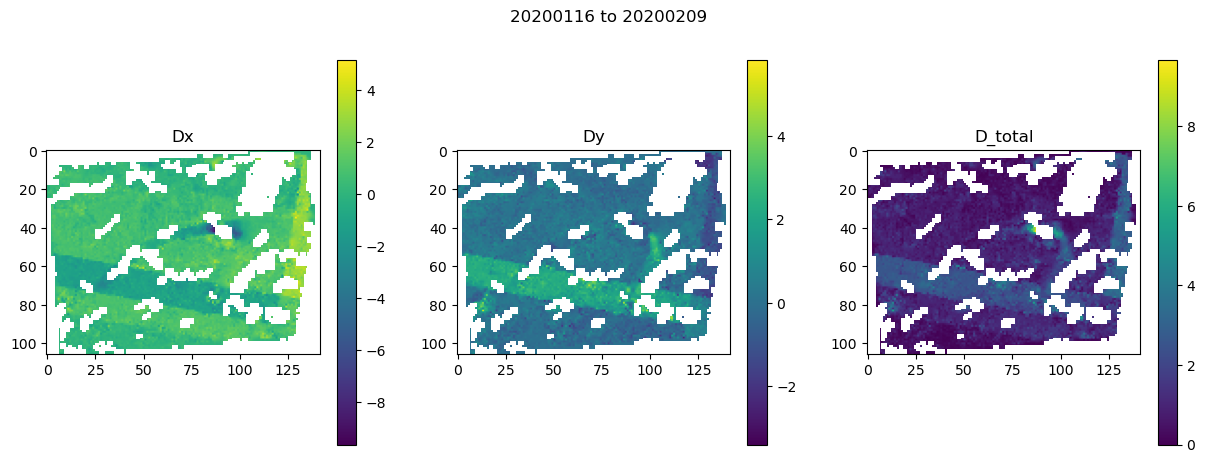

Write Outputs Start!!!
Offset.mat written.
Offset.tif written.
Velocity.tif written.
Write Outputs Done!!!
0.013400077819824219
20200116 20200214
PS_20200116_clipped.tif PS_20200214_clipped.tif
removed window_rdr_off2vel_y_vec.tif
removed window_location.tif
removed window_rdr_off2vel_x_vec.tif
Old files cleared.

Obtained DEM info.

Processing optical images with geogrid.

Optical images coregistered.

20200116 20200214

Reading input images locally from files

Optical Image parameters: 
X-direction coordinate: 771000.0  5.0
Y-direction coordinate: 4288525.0  -5.0
Dimensions: 2849  2125

Map inputs: 
EPSG: 32642
Smallest Allowable Chip Size in m: 100
Repeat Time: 2505600.0
XLimits: 771000.0  785245.0
YLimits: 4277900.0  4288525.0
Extent in km: 14.245  10.625
DEM: /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_100m.tif
Slopes: /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_dhdx_100m.tif  /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_dhdy_100m.tif

Outputs: 
Window locations: window

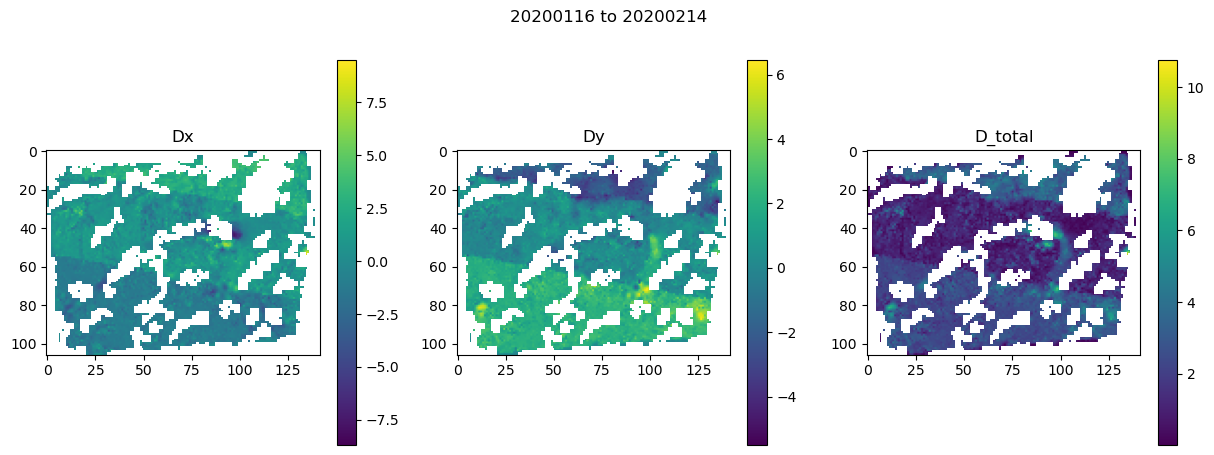

Write Outputs Start!!!
Offset.mat written.
Offset.tif written.
Velocity.tif written.
Write Outputs Done!!!
0.023317813873291016
20200116 20200219
PS_20200116_clipped.tif PS_20200219_clipped.tif
removed window_rdr_off2vel_y_vec.tif
removed window_location.tif
removed window_rdr_off2vel_x_vec.tif
Old files cleared.

Obtained DEM info.

Processing optical images with geogrid.

Optical images coregistered.

20200116 20200219

Reading input images locally from files

Optical Image parameters: 
X-direction coordinate: 771000.0  5.0
Y-direction coordinate: 4288525.0  -5.0
Dimensions: 2849  2125

Map inputs: 
EPSG: 32642
Smallest Allowable Chip Size in m: 100
Repeat Time: 2937600.0
XLimits: 771000.0  785245.0
YLimits: 4277900.0  4288525.0
Extent in km: 14.245  10.625
DEM: /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_100m.tif
Slopes: /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_dhdx_100m.tif  /Volumes/SGlacier/MZ/SRTM_1arc_v3_UTM42_clipped_dhdy_100m.tif

Outputs: 
Window locations: window

KeyboardInterrupt: 

In [24]:
# for all satellites
for platform in PLATFORM_LIST:
    # assign the folder path based on the platform
    if platform == 'S2': # sentinel-2
        path = s2path
        ext = '_clipped.tif' # image filename extension
        img_type = 'OPT'
        date_split_idx = 2 # split filename by underscore, index corresponds to image date
    elif platform == 'LS': # landsat
        path = LSpath
        ext = '.TIF'
        img_type = 'OPT'
        date_split_idx = 3
    elif platform == 'PS': # PlanetScope
        path = PSpath
        ext = '.tif' 
        img_type = 'OPT'
        date_split_idx = 1
    else:
        print('Platform', platform, 'not recognized. Options are "S2", "LS", "PS"')

    # record all possible images and their dates
    dates = []; files = []  
    for file in os.listdir(path):
        if file.endswith(ext):
            date = file.split('_')[date_split_idx] # grab the date from the filename
            dates.append(date); files.append(file) # store the date and filename
    files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
    files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
    files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
    files_df = files_df.reset_index(drop=True) # reset index for searching
    print("Number of files found:",len(files_df))
    
    for min_chipsize in CHIPSIZE_LIST: # MULTIPLE CHIP SIZES
        MINCHIPSIZE = min_chipsize
        
        [dem_outfile, dhdx_outfile, dhdy_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
                                                                         refvpath, vx_fname, vy_fname, 
                                                                         sr_scaling)
        #######################################################################
        # # CHOOSE OPTIONAL INPUTS: (set as '' to leave blank)
        # # 1) surface slope:
        #   dhdx = ''; dhdy = ''  
        dhdx = dempath+dhdx_outfile; dhdy = dempath+dhdy_outfile
        
        # # 2) reference velocity:
        vx = ''; vy = ''    
#         vx = refvpath+'vx_'+str(MINCHIPSIZE)+'m.tif'; vy = refvpath+'vy_'+str(MINCHIPSIZE)+'m.tif'
        
        # # 3) chip sizes:
        csminx = ''; csminy = ''
        csmaxx = ''; csmaxy = ''  
        #             csminx = refvpath+csminx_fname; csminy = refvpath+csminy_fname
        #             csmaxx = refvpath+csmaxx_fname; csmaxy = refvpath+csmaxy_fname
        
        # # 4) stable surface mask:
        ssm = ''
        #             ssm = refvpath+ssm_outfile # stable surface mask 
        
        # # 5) search range limit:
        srx = ''; sry = '' # for best results, never input search range limit
        #######################################################################
        
        for rownum in range(0,len(files_df)-1):
            if rownum == 0: # for the first row, idx1 = 0 and idx2 = 1
                idx1 = rownum
            idx2 = idx1+1 # reset index 2 as the next item 

            if idx1 < len(files_df) and idx2 < len(files_df): # don't surpass the end of the data
                # identify the successive image pairs:
                m = files_df.loc[idx1,'filename']; 

                # grab the two dates and convert to datetime objects
                d1s = m.split('_')[date_split_idx]; 
                d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); 

                # grab the dt days for all files after the first date
                files_df['dt'] = (pd.to_datetime(files_df.date,format='%Y%m%d') - d1).dt.days
                # grab all those that have the correct date:
                match_df = files_df[(files_df.dt >= min_dt) & (files_df.dt <= max_dt)] 
                if len(match_df) > 0: # if files are found with the correct date separation, continue
                    for idx, row in match_df.iterrows():
                        # grab the secondary image
                        s = row.filename
                        d2s = s.split('_')[date_split_idx]
                        d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
                        dt = d2-d1; dt = int(dt.days)

                        # run!
                        if not os.path.exists(out_path+'velocity_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif'):
                            print(d1s, d2s)
                            
                            # run geogrid and autoRIFT
                            if m is not None and s is not None:
                                print(m,s)
                                indir_m = path+m; indir_s = path+s # path to the two images

                                # ADJUST CODE TO NOT HAVE TO CHANGE THIS BETWEEN SK AND LOWELL
                                dem = dempath+dem_outfile
                                dhdx = dempath+dhdx_outfile
                                dhdy = dempath+dhdy_outfile
                                ###################### RUN GEOGRID ################################
                                run_geogrid_inhouse(out_path, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                                                    dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm)

                                ##################### PREP AUTORIFT ##############################
                                gp = out_path # identify files produced from geogrid
                                # remove all empty grids
                                for grid in os.listdir(gp): 
                                    if grid.startswith('window') and grid.endswith('.tif'):
                                        reader = rio.open(gp+grid) # read dataset
                                        data_found = False 
                                        for band in range(1,reader.count+1):
                                            testband = reader.read(band) # read in the band
                                            if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
                                                data_found = True
                                        if not data_found:
                                            print(grid, 'has no data. Removed.')
                                            os.remove(gp+grid)

                                # fill in AutoRIFT parameters using the files
                                mpflag = 0 # leave multiprocessing off

                                # GRID LOCATION (required) from window_location.tif
                                grid_location = rio.open(gp+'window_location.tif')
                                xGrid = grid_location.read(1) # 1st band in window location
                                yGrid = grid_location.read(2) # 2nd band in window location

                                # optional parameters (default None or zero until filled)
                                init_offset = None; search_range = None
                                chip_size_min = None; chip_size_max = None
                                offset2vx = None; offset2vy = None; stable_surface_mask = None
                                Dx0 = None; Dy0 = None; CSMINx0 = None
                                SRx0 = None; SRy0 = None;
                                CSMAXx0 = None; CSMAXy0 = None; SSM = None
                                noDataMask = np.zeros(xGrid.shape).astype(int)

                                if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
                                    init_offset = rio.open(gp+'window_offset.tif')
                                    Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
                                if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
                                    search_range = rio.open(gp+'window_search_range.tif')
                                    SRx0 = search_range.read(1); SRy0 = search_range.read(2)
                                if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
                                    chip_size_min = rio.open(gp+'window_chip_size_min.tif')
                                    CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
                                if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
                                    chip_size_max = rio.open(gp+'window_chip_size_max.tif')
                                    CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
                                if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
                                    offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
                                if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
                                    offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
                                if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
                                    stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
                                    noDataMask = stable_surface_mask.read(1)

                                # other parameters
                                nodata = NO_DATA_VAL # use same as in previous steps
                                geogrid_run_info=None
                                print('AutoRIFT parameters loaded.')

                                ##################### RUN AUTORIFT ##############################
                                # run autoRIFT with function
                                run_autoRIFT_inhouse(indir_m, indir_s, out_path, mpflag, xGrid, yGrid, # required parameters
                                                         FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, 
                                                         OVERSAMPLE_RATIO, MINCHIPSIZE,
                                                         Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                                                     noDataMask, nodata, geogrid_run_info=None)
                        else:
                            print('velocity_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif already exists.')
                else: # otherwise
                    print('No image pair with correct time separation found. Skip to next.')

            idx1 += 1 # just go to the next available image
            if idx2 >= len(files_df)-1:
                print('Finished searching.')
                break

## Run successive pairs of images only:

In [ ]:
# # try multiple chip sizes and sats
# for platform in PLATFORM_LIST:
#     # assign the folder path based on the platform
#     if platform == 'S2': # sentinel-2
#         path = s2path
#         ext = '_clipped.tif' # image filename extension
#         img_type = 'OPT'
#         date_split_idx = 2 # split filename by underscore, index corresponds to image date
#     elif platform == 'LS': # landsat
#         path = LSpath
#         ext = '.TIF'
#         img_type = 'OPT'
#         date_split_idx = 3
#     elif platform == 'PS': # PlanetScope
#         path = PSpath
#         ext = '.tif' 
#         img_type = 'OPT'
#         date_split_idx = 1
#     else:
#         print('Platform', platform, 'not recognized. Options are "S2", "LS", "PS"')

#     # record all possible images and their dates
#     dates = []; files = []  
#     for file in os.listdir(path):
#         if file.endswith(ext):
#             date = file.split('_')[date_split_idx] # grab the date from the filename
#             dates.append(date); files.append(file) # store the date and filename
#     files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
#     files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
#     files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
#     files_df = files_df.reset_index(drop=True) # reset index for searching
#     print("Number of files found:",len(files_df))
    
#     for min_chipsize in CHIPSIZE_LIST: # MULTIPLE CHIP SIZES
#         MINCHIPSIZE = min_chipsize
#         # generate geogrid inputs and grab outfilenames
# #         [dem_outfile, dhdx_outfile, dhdy_outfile, 
# #          vx_outfile, vy_outfile, srx_outfile, 
# #          sry_outfile, ssm_outfile, tg_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
# #                                                                          refvpath, vx_fname, vy_fname, 
# #                                                                          sr_scaling)
#         [dem_outfile, dhdx_outfile, dhdy_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
#                                                                          refvpath, vx_fname, vy_fname, 
#                                                                          sr_scaling)
#         #######################################################################
#         # # CHOOSE OPTIONAL INPUTS: (set as '' to leave blank)
#         # # 1) surface slope:
#         #   dhdx = ''; dhdy = ''  
#         dhdx = dempath+dhdx_outfile; dhdy = dempath+dhdy_outfile
        
#         # # 2) reference velocity:
#         vx = ''; vy = ''    
# #         vx = refvpath+'vx_'+str(MINCHIPSIZE)+'m.tif'; vy = refvpath+'vy_'+str(MINCHIPSIZE)+'m.tif'
        
#         # # 3) chip sizes:
#         csminx = ''; csminy = ''
#         csmaxx = ''; csmaxy = ''  
#         #             csminx = refvpath+csminx_fname; csminy = refvpath+csminy_fname
#         #             csmaxx = refvpath+csmaxx_fname; csmaxy = refvpath+csmaxy_fname
        
#         # # 4) stable surface mask:
#         ssm = ''
#         #             ssm = refvpath+ssm_outfile # stable surface mask 
        
#         # # 5) search range limit:
#         srx = ''; sry = '' # for best results, never input search range limit
#         #######################################################################
        
#         for rownum in range(0,len(files_df)-1):
#             if rownum == 0: # for the first row, idx1 = 0 and idx2 = 1
#                 idx1 = rownum
#             idx2 = idx1+1 # reset index 2 as the next item 

#             if idx1 < len(files_df) and idx2 < len(files_df): # don't surpass the end of the data
#                 # identify the successive image pairs:
#                 m = files_df.loc[idx1,'filename']; s = files_df.loc[idx2, 'filename']

#                 # grab the two dates and convert to datetime objects
#                 d1s = m.split('_')[date_split_idx]; d2s = s.split('_')[date_split_idx]
# #                 if platform == 'PS':
# #                     d1s = d1s[:-4]; d2s = d2s[:-4]
                
#                 # Skip if output already exists for this combination of parameters
#                 if not os.path.exists(out_path+'velocity_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif'):
#                     # calculate time separation
#                     d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
#                     dt = d2-d1; dt = int(dt.days)

#                     # evaluate if dates are within the appropriate time separation
#                     while (dt < min_dt or dt > max_dt): # dt is outside of appropriate time separation
#                         idx2 += 1 # increment index 2

#                         if idx2 > len(files_df)-1:
#                             print('No image pair with correct time separation found. Skip to next.')
#                             idx2 = idx1+1 # reset index 2 as the next item 
#                             m = None; s = None
#                             break

#                         # Keep looking for the correct time separation:
#                         m = files_df.loc[idx1,'filename']; s = files_df.loc[idx2, 'filename']

#                         # grab the two dates and convert to datetime objects
#                         d1s = m.split('_')[date_split_idx]; d2s = s.split('_')[date_split_idx]
#                         print(d1s, d2s)
#                         d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
#                         dt = d2-d1; dt = int(dt.days)

#                     # run geogrid and autoRIFT
#                     if m is not None and s is not None:
#                         print(m,s)
#                         indir_m = path+m; indir_s = path+s # path to the two images
                        
#                         # ADJUST CODE TO NOT HAVE TO CHANGE THIS BETWEEN SK AND LOWELL
#                         dem = dempath+dem_outfile
#                         dhdx = dempath+dhdx_outfile
#                         dhdy = dempath+dhdy_outfile
#                         ###################### RUN GEOGRID ################################
#                         run_geogrid_inhouse(out_path, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
#                                             dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm)
                        
#                         ##################### PREP AUTORIFT ##############################
#                         gp = out_path # identify files produced from geogrid
#                         # remove all empty grids
#                         for grid in os.listdir(gp): 
#                             if grid.startswith('window') and grid.endswith('.tif'):
#                                 reader = rio.open(gp+grid) # read dataset
#                                 data_found = False 
#                                 for band in range(1,reader.count+1):
#                                     testband = reader.read(band) # read in the band
#                                     if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
#                                         data_found = True
#                                 if not data_found:
#                                     print(grid, 'has no data. Removed.')
#                                     os.remove(gp+grid)

#                         # fill in AutoRIFT parameters using the files
#                         mpflag = 0 # leave multiprocessing off

#                         # GRID LOCATION (required) from window_location.tif
#                         grid_location = rio.open(gp+'window_location.tif')
#                         xGrid = grid_location.read(1) # 1st band in window location
#                         yGrid = grid_location.read(2) # 2nd band in window location

#                         # optional parameters (default None or zero until filled)
#                         init_offset = None; search_range = None
#                         chip_size_min = None; chip_size_max = None
#                         offset2vx = None; offset2vy = None; stable_surface_mask = None
#                         Dx0 = None; Dy0 = None; CSMINx0 = None
#                         SRx0 = None; SRy0 = None;
#                         CSMAXx0 = None; CSMAXy0 = None; SSM = None
#                         noDataMask = np.zeros(xGrid.shape).astype(int)

#                         if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
#                             init_offset = rio.open(gp+'window_offset.tif')
#                             Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
#                         if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
#                             search_range = rio.open(gp+'window_search_range.tif')
#                             SRx0 = search_range.read(1); SRy0 = search_range.read(2)
#                         if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
#                             chip_size_min = rio.open(gp+'window_chip_size_min.tif')
#                             CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
#                         if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
#                             chip_size_max = rio.open(gp+'window_chip_size_max.tif')
#                             CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
#                         if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
#                             offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
#                         if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
#                             offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
#                         if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
#                             stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
#                             noDataMask = stable_surface_mask.read(1)

#                         # other parameters
#                         nodata = NO_DATA_VAL # use same as in previous steps
#                         geogrid_run_info=None
#                         print('AutoRIFT parameters loaded.')

#                         ##################### RUN AUTORIFT ##############################
#                         # run autoRIFT with function
#                         run_autoRIFT_inhouse(indir_m, indir_s, out_path, mpflag, xGrid, yGrid, # required parameters
#                                                  FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, 
#                                                  OVERSAMPLE_RATIO, MINCHIPSIZE,
#                                                  Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
#                                              noDataMask, nodata, geogrid_run_info=None)
#                 else:
#                     print('velocity_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif already exists.')
#                 idx1 = idx2 # set the second image index as the new first image index
#                 if idx2 >= len(files_df)-1:
#                     print('Finished searching.')
#                     break
